In [1]:
import os
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import mobilenet_v3_large
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.progress import RichProgressBar
import pandas as pd
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from torchmetrics import AUROC, Accuracy, F1Score, Precision, Recall
from torchmetrics.classification import MulticlassROC
from sklearn.metrics import classification_report
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from tabulate import tabulate
from sklearn.metrics import confusion_matrix


In [2]:
# Hiperparámetros
BATCH_SIZE = 32
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
NUM_WORKERS = 3
TOTAL_CLASSES = 6
CONFIDENCE_THRESHOLD = 0.60
IMAGE_SIZE = (224, 224)

In [3]:
# Rutas de los archivos Excel
excel_paths = [
    '/home/emontenegrob/dataset_frames_conf/dataset_frames_1_1.xlsx',
    '/home/emontenegrob/dataset_frames_conf/dataset_frames_2_2.xlsx',
    '/home/emontenegrob/dataset_frames_conf/dataset_frames_3_3.xlsx',
    '/home/emontenegrob/dataset_frames_conf/dataset_frames_4_4.xlsx',
    '/home/emontenegrob/dataset_frames_conf/dataset_frames_5_5.xlsx',
    '/home/emontenegrob/dataset_frames_conf/dataset_frames_6_6.xlsx'
]

In [4]:
class AnimalDataset(Dataset):
    def __init__(self, excel_paths, partition, transform=None):
        dataframes = [pd.read_excel(path) for path in excel_paths]
        self.data = pd.concat(dataframes, ignore_index=True)
        self.data = self.data[(self.data['Confianza'] > CONFIDENCE_THRESHOLD) & (self.data['Partition'] == partition)]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row['Frame (imagen luego del algoritmo de detección de movimiento)']
        bbox = row['Bounding Box']
        label = row['ID']
        
        image = Image.open(image_path)
        x1, y1, x2, y2 = eval(bbox)
        image = image.crop((x1, y1, x2, y2))

        if self.transform:
            image = self.transform(image)

        return image, label - 1


In [ ]:
class AnimalDataset(Dataset):
    def __init__(self, excel_paths, partition, transform=None):
        dataframes = [pd.read_excel(path) for path in excel_paths]
        self.data = pd.concat(dataframes, ignore_index=True)
        self.data = self.data[(self.data['Confianza'] > CONFIDENCE_THRESHOLD) & (self.data['Partition'] == partition)]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row['Frame (imagen luego del algoritmo de detección de movimiento)']
        bbox = row['Bounding Box']
        label = row['ID']
        
        image = Image.open(image_path)
        x1, y1, x2, y2 = eval(bbox)
        image = image.crop((x1, y1, x2, y2))

        if self.transform:
            image = self.transform(image)

        return image, label - 1

class AnimalDataModule(pl.LightningDataModule):
    def __init__(self, excel_paths, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.excel_paths = excel_paths
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        self.train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomCrop((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.train_dataset = AnimalDataset(self.excel_paths, partition='train', transform=self.train_transform)
        self.val_dataset = AnimalDataset(self.excel_paths, partition='validation', transform=self.test_transform)
        self.test_dataset = AnimalDataset(self.excel_paths, partition='test', transform=self.test_transform)
        
# importnate preguntar al tutor si se peude hacer shuffle en el test
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

In [6]:
def visualize_sample_images_notebook(data_module, num_samples=2):
    """
    Visualiza 'num_samples' imágenes por clase del conjunto de entrenamiento en el notebook de manera eficiente.
    """
    if not hasattr(data_module, 'train_dataset'):
        data_module.setup('fit')
    
    dataset = data_module.train_dataset
    df = dataset.data  # Accedemos directamente al DataFrame

    fig, axs = plt.subplots(TOTAL_CLASSES, num_samples, figsize=(num_samples*4, TOTAL_CLASSES*4))
    fig.suptitle('Sample Images by Class', fontsize=16)

    for class_idx in range(TOTAL_CLASSES):
        # Filtrar el DataFrame por clase
        class_df = df[df['ID'] - 1 == class_idx]
        
        # Seleccionar aleatoriamente 'num_samples' muestras
        samples = class_df.sample(n=min(num_samples, len(class_df)))
        
        for i, (_, row) in enumerate(samples.iterrows()):
            image_path = row['Frame (imagen luego del algoritmo de detección de movimiento)']
            bbox = row['Bounding Box']
            
            # Cargar y recortar la imagen
            image = Image.open(image_path)
            x1, y1, x2, y2 = eval(bbox)
            image = image.crop((x1, y1, x2, y2))
            
            # Redimensionar la imagen (opcional, para consistencia)
            image = image.resize((224, 224))
            
            # Mostrar la imagen
            ax = axs[class_idx][i] if num_samples > 1 else axs[class_idx]
            ax.imshow(image)
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Class {class_idx}')

    plt.tight_layout()
    plt.show()


In [7]:
def calculate_class_weights(data_module):
    labels = []
    for batch in data_module.train_dataloader():
        _, label = batch
        labels.extend(label.numpy())
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    return torch.tensor(class_weights, dtype=torch.float32)

In [8]:
class LightningMobileNetV3(pl.LightningModule):
    def __init__(self, learning_rate=LEARNING_RATE, num_classes=TOTAL_CLASSES, class_weights=None):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.class_weights = class_weights
        
        self.model = mobilenet_v3_large(pretrained=True)
        self.model.classifier[3] = nn.Linear(self.model.classifier[3].in_features, num_classes)
        
        # Inicializar las listas de historial
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Congelar las primeras capas
        for param in self.model.features[:10].parameters():
            param.requires_grad = False
        
        # Descongelar las últimas capas de características y el clasificador
        for param in self.model.features[10:].parameters():
            param.requires_grad = True
        for param in self.model.classifier.parameters():
            param.requires_grad = True

        self.train_acc = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=self.num_classes)

        self.train_f1 = F1Score(task="multiclass", num_classes=self.num_classes, average='macro')
        self.val_f1 = F1Score(task="multiclass", num_classes=self.num_classes, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=self.num_classes, average='macro')

        self.train_precision = Precision(task="multiclass", num_classes=self.num_classes, average='macro')
        self.val_precision = Precision(task="multiclass", num_classes=self.num_classes, average='macro')
        self.test_precision = Precision(task="multiclass", num_classes=self.num_classes, average='macro')

        self.train_recall = Recall(task="multiclass", num_classes=self.num_classes, average='macro')
        self.val_recall = Recall(task="multiclass", num_classes=self.num_classes, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=self.num_classes, average='macro')

        self.train_auc = AUROC(task="multiclass", num_classes=self.num_classes, average='macro')
        self.val_auc = AUROC(task="multiclass", num_classes=self.num_classes, average='macro')
        self.test_auc = AUROC(task="multiclass", num_classes=self.num_classes, average='macro')

        self.test_roc = MulticlassROC(num_classes=self.num_classes)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        images, labels = batch
        class_weights = self.class_weights.to(self.device)
        logits = self(images)
        loss = nn.CrossEntropyLoss(weight=class_weights)(logits, labels)
        probs = torch.softmax(logits, dim=1)
        return loss, probs, labels

    def training_step(self, batch, batch_idx):
        loss, probs, labels = self._shared_step(batch)
        acc = self.train_acc(probs, labels)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log('train_f1', self.train_f1(probs, labels), on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log('train_precision', self.train_precision(probs, labels), on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log('train_recall', self.train_recall(probs, labels), on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log('train_auc', self.train_auc(probs, labels), on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, probs, labels = self._shared_step(batch)
        acc = self.val_acc(probs, labels)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log('val_f1', self.val_f1(probs, labels), on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log('val_precision', self.val_precision(probs, labels), on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log('val_recall', self.val_recall(probs, labels), on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log('val_auc', self.val_auc(probs, labels), on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)

    def on_test_epoch_start(self):
        self.test_step_outputs = []
        
    def test_step(self, batch, batch_idx):
        loss, probs, labels = self._shared_step(batch)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', self.test_acc(probs, labels), on_step=False, on_epoch=True)
        self.log('test_f1', self.test_f1(probs, labels), on_step=False, on_epoch=True)
        self.log('test_precision', self.test_precision(probs, labels), on_step=False, on_epoch=True)
        self.log('test_recall', self.test_recall(probs, labels), on_step=False, on_epoch=True)
        self.log('test_auc', self.test_auc(probs, labels), on_step=False, on_epoch=True)
        self.test_roc.update(probs, labels)
        
        output = {'loss': loss, 'probs': probs, 'labels': labels}
        self.test_step_outputs.append(output)
        return output
    
    def on_train_epoch_end(self):
        # Acumular los valores de pérdida y precisión
        train_loss = self.trainer.callback_metrics['train_loss'].cpu().item()
        val_loss = self.trainer.callback_metrics['val_loss'].cpu().item()
        train_acc = self.trainer.callback_metrics['train_acc'].cpu().item()
        val_acc = self.trainer.callback_metrics['val_acc'].cpu().item()

        self.train_loss_history.append(train_loss)
        self.val_loss_history.append(val_loss)
        self.train_acc_history.append(train_acc)
        self.val_acc_history.append(val_acc)

    def on_fit_end(self):
        # Crear gráficos de pérdida y precisión al final del entrenamiento
        epochs = range(len(self.train_loss_history))

        plt.figure(figsize=(12, 10))
        
        # Gráfico de pérdida
        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.train_loss_history, 'b-', label='Train Loss')
        plt.plot(epochs, self.val_loss_history, 'r-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Gráfico de precisión
        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.train_acc_history, 'b-', label='Train Accuracy')
        plt.plot(epochs, self.val_acc_history, 'r-', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        
        # Guardar la figura en TensorBoard
        self.logger.experiment.add_figure('Training History', plt.gcf())
        plt.close()

    def on_test_epoch_end(self):
        # Recopilación de todas las predicciones y etiquetas
        all_preds = []
        all_labels = []
        for output in self.test_step_outputs:
            all_preds.extend(output['probs'].cpu().numpy())
            all_labels.extend(output['labels'].cpu().numpy())

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        # Binarizar las etiquetas
        all_labels_bin = label_binarize(all_labels, classes=list(range(self.num_classes)))
        
        # Calcular AUC-ROC para cada clase
        fpr = {}
        tpr = {}
        roc_auc = {}
        for i in range(self.num_classes):
            fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_preds[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Calcular AUC-ROC micro y macro
        fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_bin.ravel(), all_preds.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        fpr["macro"] = np.unique(np.concatenate([fpr[i] for i in range(self.num_classes)]))
        tpr["macro"] = np.zeros_like(fpr["macro"])
        for i in range(self.num_classes):
            tpr["macro"] += np.interp(fpr["macro"], fpr[i], tpr[i])
        tpr["macro"] /= self.num_classes
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Crear la gráfica ROC
        plt.figure(figsize=(14, 10))

        plt.plot(fpr["micro"], tpr["micro"],
                 label='Micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='Macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        for i in range(self.num_classes):
            plt.plot(fpr[i], tpr[i], lw=2,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title('Receiver Operating Characteristic to Multi-Class', fontsize=16)
        plt.legend(loc="lower right", fontsize=10)

        # Guardar la figura en TensorBoard
        self.logger.experiment.add_figure('ROC Curve', plt.gcf())

        # Cerrar la figura para liberar memoria
        plt.close()

        # Calcular y registrar el classification report
        all_preds_class = all_preds.argmax(axis=1)
        report = classification_report(all_labels, all_preds_class, output_dict=True)
        
        # Convertir el reporte a un DataFrame
        df_report = pd.DataFrame(report).transpose()
        
        # Renombrar el índice para mayor claridad
        df_report.index.name = 'Class'
        df_report.reset_index(inplace=True)
        
        # Redondear los valores numéricos a 3 decimales
        df_report = df_report.round(3)
        
        # Crear una tabla estilizada
        table = tabulate(df_report, headers='keys', tablefmt='pretty', showindex=False)
        
        # Registrar la tabla en TensorBoard como texto
        self.logger.experiment.add_text('Classification Report', f'<pre>{table}</pre>')
        
        # También puedes guardar la tabla como una imagen si lo prefieres
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.axis('off')
        ax.table(cellText=df_report.values,
                 colLabels=df_report.columns,
                 cellLoc='center',
                 loc='center')
        plt.title('Classification Report')
        self.logger.experiment.add_figure('Classification Report Table', fig)
        plt.close(fig)

        # Visualizar el classification report como un heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(df_report.iloc[:, 1:5], annot=True, cmap='YlGnBu')
        plt.title('Classification Report Heatmap')
        self.logger.experiment.add_figure('Classification Report Heatmap', plt.gcf())
        plt.close()
        
        # Calcular la matriz de confusión
        cm = confusion_matrix(all_labels, all_preds_class)
        
        # Crear una figura para la matriz de confusión
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        self.logger.experiment.add_figure('Confusion Matrix', plt.gcf())
        plt.close()

        # Calcular la matriz de confusión normalizada
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Crear una figura para la matriz de confusión normalizada
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
        plt.title('Normalized Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        self.logger.experiment.add_figure('Normalized Confusion Matrix', plt.gcf())
        plt.close()

        # Limpiar los outputs para la siguiente época
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


    def on_fit_start(self):
        # Registrar la estructura del modelo en TensorBoard
        self.logger.experiment.add_graph(self, torch.rand(1, 3, 224, 224).to(self.device))

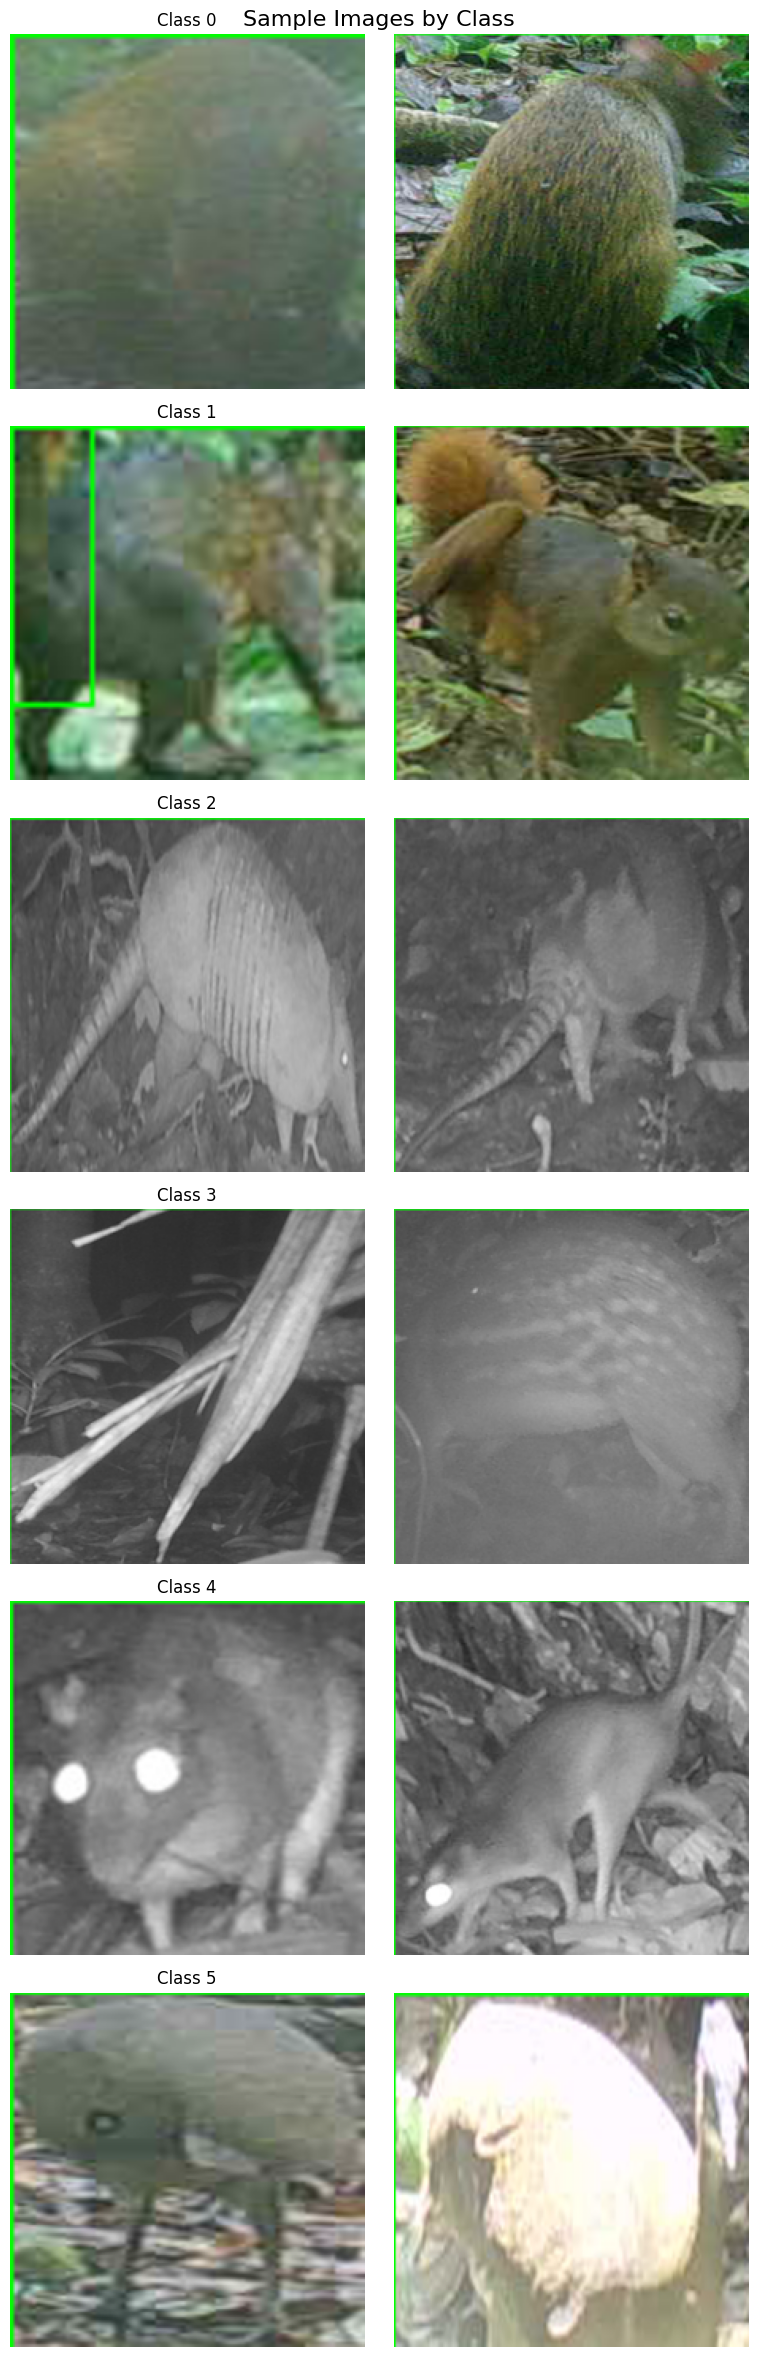

In [9]:
# Inicializar el DataModule
data_module = AnimalDataModule(excel_paths)
data_module.setup(stage='fit')
# Visualizar las imágenes
visualize_sample_images_notebook(data_module)

# Calcular los pesos de clase
class_weights = calculate_class_weights(data_module)

In [11]:
# Configurar el logger de TensorBoard
logger = TensorBoardLogger("tb_logs_mobilenetv3_test1", name="mobilenetv3_animals_jocotoco_conf60")

# Inicializar el modelo
lightning_model = LightningMobileNetV3(learning_rate=LEARNING_RATE, num_classes=TOTAL_CLASSES, class_weights=class_weights)

# Configurar los callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints_mobilenetv3',
    monitor='val_loss',
    filename='mobilenetv3-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min'
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min'
)

progress_bar_callback = RichProgressBar()

# Configurar el Trainer
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=[checkpoint_callback, early_stopping_callback, progress_bar_callback],
    accelerator='gpu',
    devices=1,
    logger=logger,
    log_every_n_steps=50,
    deterministic=True
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [12]:
# Entrenamiento
trainer.fit(lightning_model, datamodule=data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name            ┃ Type                ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ model           │ MobileNetV3         │  4.2 M │ train │
│ 1  │ train_acc       │ MulticlassAccuracy  │      0 │ train │
│ 2  │ val_acc         │ MulticlassAccuracy  │      0 │ train │
│ 3  │ test_acc        │ MulticlassAccuracy  │      0 │ train │
│ 4  │ train_f1        │ MulticlassF1Score   │      0 │ train │
│ 5  │ val_f1          │ MulticlassF1Score   │      0 │ train │
│ 6  │ test_f1         │ MulticlassF1Score   │      0 │ train │
│ 7  │ train_precision │ MulticlassPrecision │      0 │ train │
│ 8  │ val_precision   │ MulticlassPrecision │      0 │ train │
│ 9  │ test_precision  │ MulticlassPrecision │      0 │ train │
│ 10 │ train_recall    │ MulticlassRecall    │      0 │ train │
│ 11 │ val_recall      │ MulticlassRecall    │      0 │ train │
│ 12 │ test_recall     │ MulticlassRecall    │      0 │ train │
│ 13 │ train_auc       │ MulticlassAUROC     │      0 │ train │
│ 14 │ val_auc         │ MulticlassAUROC     │      0 │ train │
│ 15 │ test_auc        │ MulticlassAUROC     │      0 │ train │
│ 16 │ test_roc        │ MulticlassROC       │      0 │ train │
└────┴─────────────────┴─────────────────────┴────────┴───────┘

Trainable params: 4.0 M                                                                                            
Non-trainable params: 159 K                                                                                        
Total params: 4.2 M                                                                                                
Total estimated model params size (MB): 16                                                                         
Modules in train mode: 271                                                                                         
Modules in eval mode: 0

Output()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is 
incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: TorchMetricsUserWarning: You are 
trying to use a metric in deterministic mode on GPU that uses `torch.cumsum`, which is currently not supported. The
tensor will be copied to the CPU memory to compute it and then copied back to GPU. Expect some slowdowns.
  warnings.warn(*args, **kwargs)  # noqa: B028

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in 
targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in 
targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028

In [13]:
# Cargar el mejor modelo
best_model_path = checkpoint_callback.best_model_path
best_model = LightningMobileNetV3.load_from_checkpoint(best_model_path)
print(f"Mejor modelo guardado en: {best_model_path}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mejor modelo guardado en: /home/emontenegrob/codigo_solo_tesis_movilenetv3_test_conf60/checkpoints_mobilenetv3/mobilenetv3-epoch=06-val_loss=0.14.ckpt


In [14]:
# Evaluación en el conjunto de prueba
trainer.test(model=best_model, datamodule=data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: TorchMetricsUserWarning: You are 
trying to use a metric in deterministic mode on GPU that uses `torch.cumsum`, which is currently not supported. The
tensor will be copied to the CPU memory to compute it and then copied back to GPU. Expect some slowdowns.
  warnings.warn(*args, **kwargs)  # noqa: B028

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in 
targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in 
targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9424017071723938     │
│         test_auc          │   0.011335459537804127    │
│          test_f1          │    0.8322317600250244     │
│         test_loss         │    0.21618250012397766    │
│      test_precision       │    0.8438116908073425     │
│        test_recall        │    0.8245827555656433     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.21618250012397766,
  'test_acc': 0.9424017071723938,
  'test_f1': 0.8322317600250244,
  'test_precision': 0.8438116908073425,
  'test_recall': 0.8245827555656433,
  'test_auc': 0.011335459537804127}]

In [ ]:
# Visualización de TensorBoard (si estás ejecutando en un notebook)
%load_ext tensorboard
%tensorboard --logdir tb_logs_mobilenetv3_test1

Reusing TensorBoard on port 6007 (pid 284135), started 8 days, 13:44:39 ago. (Use '!kill 284135' to kill it.)

<IPython.core.display.Javascript object>